In [1]:
#https://pypi.python.org/pypi/Assimulo
#http://www.jmodelica.org/assimulo_home/tutorial_imp.html
#https://anaconda.org/search?q=assimulo

In [2]:
#conda install -c conda-forge assimulo

In [49]:
#http://www.jmodelica.org/assimulo_home/examples.html#
#http://www.jmodelica.org/assimulo_home/_modules/assimulo/examples/radau5dae_time_events.html#run_example

Final Run Statistics: supersatICE 

 Number of steps                                 : 366
 Number of function evaluations                  : 535
 Number of Jacobian evaluations                  : 72
 Number of function eval. due to Jacobian eval.  : 648
 Number of error test failures                   : 25
 Number of nonlinear iterations                  : 535
 Number of nonlinear convergence failures        : 0
 Number of time events                           : 1

Solver options:

 Solver                       : IDA (BDF)
 Maximal order                : 5
 Suppressed algebr. variables : False
 Tolerances (absolute)        : 1e-06
 Tolerances (relative)        : 1e-06

Simulation interval    : 0.0 - 10.0 seconds.
Elapsed simulation time: 0.033449999999998425 seconds.


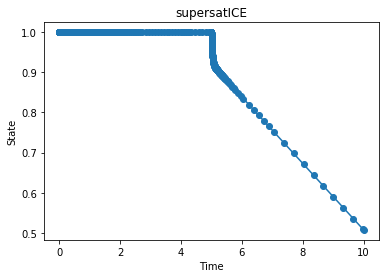

In [31]:
#CVode and IDA can use Assimulos method through the option ”external_event_detection”

import numpy as np

import numpy as N
import pylab as P
from assimulo.solvers import Radau5DAE, IDA
from assimulo.problem import Implicit_Problem

class supersatICEPolProblem(Implicit_Problem):
    def __init__(self, **kargs):
        Implicit_Problem.__init__(self, **kargs)
        self.name = 'supersatICE'
        self.my = 0.
        
    #Define the residual
    def res(self,t,y,yd):
        #Tvar, Pconst
        #i:   0     1
        #y:  nL,   nI, 
        #yd: dnL, dnI,
                #dnL=-dnI=dnI->L
        res_0 = (yd[0])-(-yd[1])                 #BALMASS
                #dnI->L=k*(Tsis-Teq)

        if (y[1]>=-.1 and y[0]>=-.1):
            res_1 = (yd[0])-(1.-np.exp(-1.*t/1e0))*self.my*(1e-1*(y[8]-273.))  #MODELO DE TRANSFASE
        else:
            res_1 = (yd[0])-(0.)
        pass
                #barHL=CpL(Tsis-Tref)
        res_2 = (y[2]) - ( 1.*(y[8]-273.15) )     #PROP ENERGIA-T
                #barHI=CpI(Tsis-Tref)
        res_3 = (y[3]) - ( 10.*(y[8]-273.15)-500. )     #PROP ENERGIA-T
                #HL=nLbarHL
        res_4 = (y[4])-(y[0]*y[2])     #PROP
                #HI=nIbarHI
        res_5 = (y[5])-(y[1]*y[3])     #PROP
                #Hsis=HL+HI
        res_6 = (y[6])-(y[4]+y[5])     #BALENERGIA
                #dHsis=q => (dH=dU+PdV, dU = q+w, w=PdV :. dH=q)
        res_7 = (yd[6])-(y[7])         #MODELO DE TRANSCAL1/2
                #q=k(Tsis-Tbath) .OR. q=0
        #res_8 =  (y[7])-(0.) #isolation
        res_8 =  (y[7])-(1.-np.exp(-1.*t))*(1e0*(-y[8]+230.)) #MODELO DE TRANSCAL2/2
        return np.array([res_0,res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_8])
    
    def time_events(self, t,y,yd,sw):
        events = [5.0]
        for ev in events:
            if t < ev:
                tnext = ev
                break
            else:
                tnext = None
        return tnext
        
    def handle_event(self, solver, event_info):
        self.my = 1.

def run_example(with_plots=True):
    
    y0  = [1.0, #nL
           0., #nI
           1.*(298.-273.15), #hL
           10.*(298.-273.15)-500., #hI
           1.*1.*(298.-273.15), #HL
           0.*(10.*(298.-273.15)-500.), #HI
           1.*1.*(298.-273.15) + 0.*(10.*(298.-273.15)-500.), #Hsis
           0, #q
           298, #T
          ] #Initial states
    yd0 = [0., #dnL
           0., #dnI
           0., #dhl ~
           0., #dhI ~
           0., #dHL ~
           0., #dHI ~
           0., #dHsis
           0.,   #dq
           0., #dT
          ] #Initial state derivatives
    
    #Define an extended Assimulo problem
    imp_mod = supersatICEPolProblem(y0=y0,yd0=yd0)

    #Define an explicit solver
    imp_sim = IDA(imp_mod) #Create a Radau5 solver

    #Simulate
    t, y, yd = imp_sim.simulate(10.) #Simulate 8 seconds
    
    #Plot
    if with_plots:
        P.plot(t,y[:,0], marker='o')
        P.xlabel('Time')
        P.ylabel('State')
        P.title(imp_mod.name)
        P.show()
    
    #Basic test
    x1 = y[:,0]
    return imp_mod, imp_sim

mod,sim = run_example()

In [26]:
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

nsis=9
labels="nL,nI,hL,hI,HL,HI,Hsis,q,T".replace(" ","").split(",")
labesd=dict(zip(labels,range(nsis)))

print(labesd)
def ids(words):
    idi=[]
    for word in words.replace(" ","").split(","):
        idi+=[labesd[word]]
    return idi

{'nL': 0, 'nI': 1, 'hL': 2, 'hI': 3, 'HL': 4, 'HI': 5, 'Hsis': 6, 'q': 7, 'T': 8}


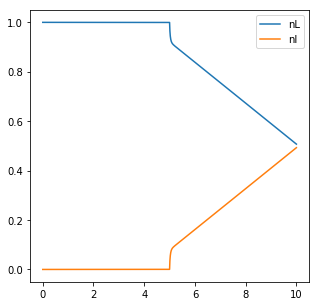

In [32]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("nL,nI"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

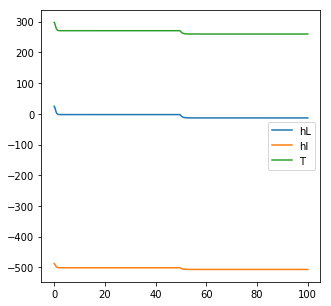

In [92]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("hL,hI,T"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

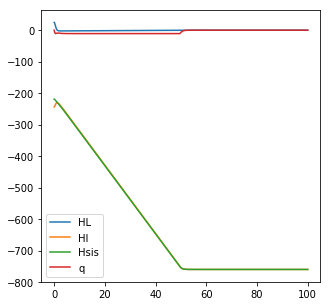

In [93]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("HL,HI,Hsis,q"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()

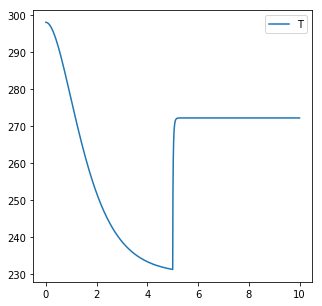

In [33]:
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111)
for k in ids("T"):
    yaxis=(sim.y_sol[i][k] for i in range(len(sim.y_sol)))
    ax.plot(sim.t_sol,np.fromiter(yaxis,dtype=np.float),label=labels[k])
ax.legend(loc=0)
fig.canvas.draw()